# Team Members: Jaden Phan, Sarah Morrison

Dataset: https://www.kaggle.com/datasets/tunguz/nba-forecasts



# Introduction:
The dataset we chose to use is an nba elo dataset. For the purposes of this project, elo is a score that describes a team's overall performance, measured by its deviation from 1300.

### Dataset Description
nba_elo.csv: contains game-by-game "elo" ratings and forecasts back to 1946

Both datasets contain the same 24 column attributes. Here are the most important attributes to our study:
* **date**: yyyy-mm-dd of the game
* **season**: yyyy of season
* **elo1_pre**: each team starts the season with a rating of 1300. After every win or loss, they gain or lose elo based on their opponents relative score and game performance.
* **elo_prob**: analyst predicted chance of team winning
* **elo_post**: rating of each team after the result of the game
* **score**: score of the game for each team for each game

### We want to predict the winner of any given game in the dataset.
To do this, we will be leveraging the data from nba_elo.csv which contains game-by-game data that dates back to 1946. By training the classifier on over 60 years of past games, we hope it will be able to predict the winners of the games from any season in the dataset.

### Implementation/Technical Merit
* This dataset lacks documentation so we will need to spend some time understanding each attribute as well as deciding units for numerical values.
* There are some attributes with obscure names that we will need to understand as well.
* About 50% of the attributes have a majority of NULL values so we will need to decide how to interpret and handle these missing values.
* Our dataset is about 71,000 instances of data, we will likely need to **randomly sample** or cut down the size of samples in-order to reduce computing time. That being said having such a large dataset allows us to have a large amount of diversity in our data regardless of how we split or sample.

### Potential Impact of Results

Teams:

This could be useful for the teams in terms of strategy and management. It could also help the teams manage their fan engagement and marketing for the upcoming season.

Fans:

For fans, this could be useful for betting. This could also be useful for fans for increased general interest in their team, or rival teams.

## Findings

We found that Naive Bayes was our highest performing classifier with an accuracy score of 72%. In general it is hard to predict which team will win a given matchup do to the natural unpredictability of sports.

### Import libraries

In [109]:
# some useful mysklearn package import statements and reloads
import importlib
import pandas as pd
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.mysimplelinearregressor
importlib.reload(mysklearn.mysimplelinearregressor)
import mysklearn.mysimplelinearregressor as linear

train = MyPyTable().load_from_file('input_data/nba_elo.csv')
test = MyPyTable().load_from_file('input_data/nba_elo_latest.csv')



### Randomly Down-Sample Dataset
Since our training set nba_elo.csv has over 70,000 instances, we need to down sample in-order to make compute time reasonable. We found that **10,000** instances gave us reasonable accuracy with reasonable compute time

In [110]:
importlib.reload(mysklearn.mypytable)
small_train = train.random_down_sample(num_rows=10000)
small_train.pretty_print()



date          season    neutral  playoff    team1    team2      elo1_pre    elo2_pre    elo_prob1    elo_prob2  elo1_post         elo2_post         carm-elo1_pre     carm-elo2_pre     carm-elo_prob1       carm-elo_prob2        carm-elo1_post    carm-elo2_post    raptor1_pre       raptor2_pre       raptor_prob1         raptor_prob2          score1    score2
----------  --------  ---------  ---------  -------  -------  ----------  ----------  -----------  -----------  ----------------  ----------------  ----------------  ----------------  -------------------  --------------------  ----------------  ----------------  ----------------  ----------------  -------------------  --------------------  --------  --------
1990-12-07      1991          0             GSW      DET         1488.68     1640.34    0.426195     0.573805   1495.3727         1633.6504                                                                                                                                             

## Create new column, this will be the class we are predicting
We want to predict the winner of games based on past data, so we will create a new column called "winner"
* winner = 1 when team 1 wins
* winner = 0 when team 2 wins

In [111]:
importlib.reload(mysklearn.myutils)

# First we will calculate the winners
train_winner = myutils.calculate_winners(small_train)

# Next we add a new column to both test and train sets
small_train.add_column("winner", train_winner)

## EDA - Visualizations

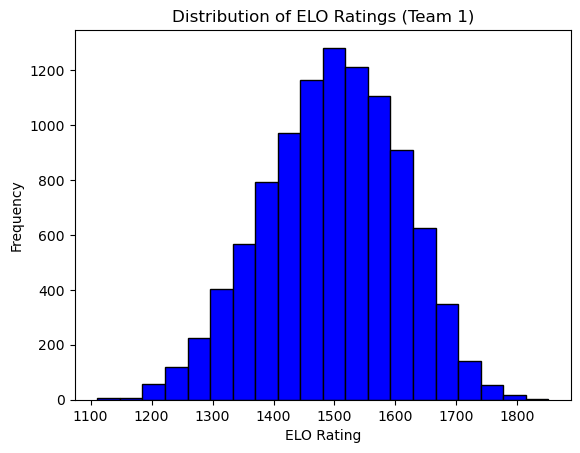

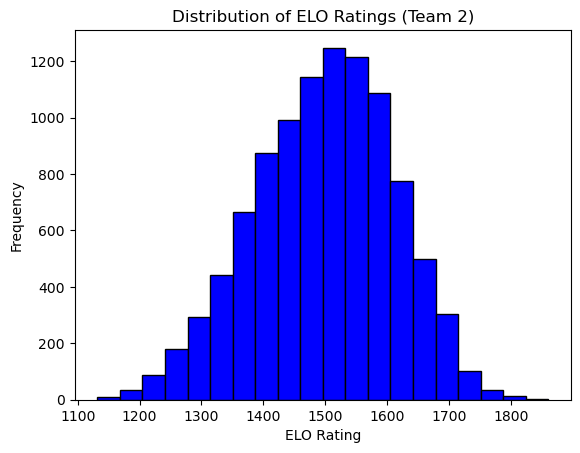

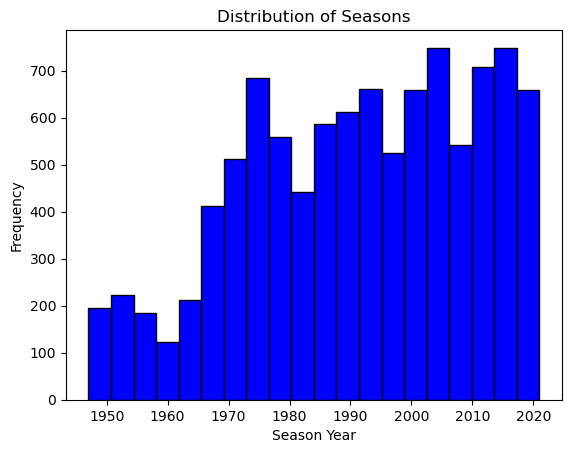

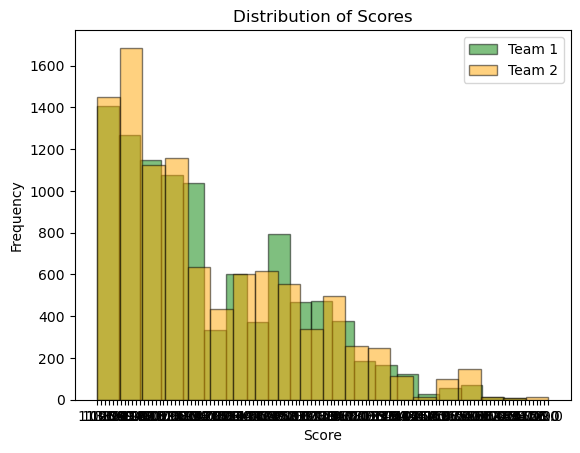

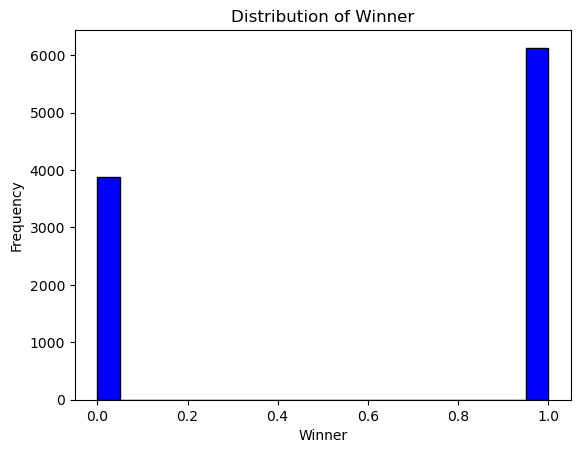

In [112]:
# Distribution of ELO ratings
plt.hist(small_train.get_column('elo1_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 1)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of ELO ratings
plt.hist(small_train.get_column('elo2_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 2)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of Seasons
plt.hist(small_train.get_column('season'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Seasons")
plt.xlabel("Season Year")
plt.ylabel("Frequency")
plt.show()

# Distribution of Scores
plt.hist(small_train.get_column('score1'), bins=20, alpha=0.5, label='Team 1', color='green', edgecolor='black')
plt.hist(small_train.get_column('score2'), bins=20, alpha=0.5, label='Team 2', color='orange', edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Distribution of Winner
plt.hist(small_train.get_column('winner'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Winner")
plt.xlabel("Winner")
plt.ylabel("Frequency")
plt.show()




## Data Analysis
Here we can takeaway a few key aspects of the dataset. 
* Elo Ratings (Figure 1 and 2):
    * Despite all teams starting at 1300, we can see the median elo rating is around 1500, this indicates that on average teams were good and that very few teams were performing extremely poorly over time.
* Scores (Figure 4):
    * We can see that over the course of about 60 years, the average score of each team during a game was about 100.
* Winner (Figure 5):
    * This is the class we are trying to predict. We can see that there is some imbalance here as team1 tends to win more than team2. This indicates to us that the home team, which is the team presented first, won more often. This is actually a real phenomenon called "home court advantage"

## Preliminary Classifications

### Define X_train, y_train, X_text, y_test
Since winner, the class we are predicting, is the last column, we can easily split the datasets into X_train, y_train, X_test, and y_test.

In [113]:
# Define X_train, y_train, X_test, y_test
train_attributes = ['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'team1', 'team2', 'score1','score2' ]

attribute_indexes = [small_train.column_names.index(attr) for attr in train_attributes]


X = [[row[index] for index in attribute_indexes] for row in small_train.data]
y = small_train.get_column("winner")

X_train, X_test, y_train, y_test = myevaluation.train_test_split(X, y)




### Dummy Classifier

In [114]:
importlib.reload(mysklearn.myevaluation)
dummy = MyDummyClassifier()
myevaluation.evaluate_classifier(dummy, X_train, y_train, X_test, y_test, "Dummy Classifier")


=== Dummy Classifier ===
Evaluation results for Dummy Classifier:
Accuracy: 0.61
Error Rate: 0.39
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 1272], [0, 2028]]


### Discretize and Preprocess Data
For the following classifiers we need to discretize the numerical data into categories.

In [115]:
importlib.reload(mysklearn.myutils)
X_train_discretized = myutils.preprocess_data(X_train)
X_test_discretized = myutils.preprocess_data(X_test)


### Naive Bayes Classifier

In [116]:
importlib.reload(mysklearn.myevaluation)
naive_bayes = MyNaiveBayesClassifier()
myevaluation.evaluate_classifier(naive_bayes, X_train_discretized, y_train, X_test_discretized, y_test, "Naive Bayes Classifier")


=== Naive Bayes Classifier ===
Evaluation results for Naive Bayes Classifier:
Accuracy: 0.72
Error Rate: 0.28
Precision: 0.63
Recall: 0.66
F1 Score: 0.65
Confusion Matrix:
[[839, 433], [486, 1542]]


### Decision Trees Classifier

In [117]:
importlib.reload(mysklearn.myevaluation)
importlib.reload(mysklearn.myclassifiers)
dt = MyDecisionTreeClassifier()
myevaluation.evaluate_classifier(dt, X_train_discretized, y_train, X_test_discretized, y_test, "Decision Tree Classifier")


=== Decision Tree Classifier ===
Evaluation results for Decision Tree Classifier:
Accuracy: 0.94
Error Rate: 0.06
Precision: 0.93
Recall: 0.91
F1 Score: 0.92
Confusion Matrix:
[[1152, 120], [81, 1947]]


### Random Forest Classifiers

In [118]:
importlib.reload(mysklearn.myevaluation)
random_forest = MyRandomForestClassifier(n=10, m=8, f=2, M=2, random_state=42)
myevaluation.evaluate_classifier(random_forest, X_train_discretized, y_train, X_test_discretized, y_test, "Random Forest Classifier")


=== Random Forest Classifier ===
Evaluation results for Random Forest Classifier:
Accuracy: 0.67
Error Rate: 0.33
Precision: 0.57
Recall: 0.55
F1 Score: 0.56
Confusion Matrix:
[[701, 571], [531, 1497]]


# Classification Results and Takeaways
We decided to use the Dummy, Naive Bayes, Decision Tree, and Random Forest classifiers for this dataset. The Dummy classifier gave us a 61% accuracy, which is relatively low but its main purpose is to serve as a benchmark for our other models. Naive Bayes gave us a respectable 72% accuracy, we've determined this to be one of our best models. Decision Tree gave us a 94% accuracy, and while this is great on the surface, we think this accuracy is actually a result of over fitting to the dataset. Finally, Random Forests gave us somewhere in the neighborhood of 65-70%, similar in performance to Naive Bayes, but with an increased compute time.

Overall, Naive Bayes is our best performing model after running each classifier through a modified version of the classifier evaluation function we implemented in past PA's. Although Decision Tree's performed much better with a 94% accuracy, we think this could be a result of over-fitting. While 72% isn't incredibly accurate, sports is inherently hard to predict because of the unpredictable nature of an athletes performance. If we were to approach this project again, I would consider looking into other classes to predict on. If we could find the finances of each of the teams, maybe we could find some way to predict performance or elo rating based on the amount of money each team spent. But this could also run into some of the issues that are associated with analyzing trends in the sports field and trying to extrapolate that onto future events.


# Acknowledgements
### Sources:
Dataset: https://www.kaggle.com/datasets/tunguz/nba-forecasts

Since the dataset lacked documentation, we utilized ChatGPT to help analyze the dataset in order help us understand the attributes in the dataset. 